<a href="https://colab.research.google.com/github/sravanisasu/BERT_Regression/blob/main/BERT_10K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup GPU**

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Extract data from github**

In [2]:
!git clone https://github.com/sravanisasu/10k-sample

Cloning into '10k-sample'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9557 (delta 1), reused 1 (delta 0), pack-reused 9548
Receiving objects: 100% (9557/9557), 158.15 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Checking out files: 100% (10020/10020), done.


**Required packages and imports**

In [3]:
% pip install transformers

     |████████████████████████████████| 2.0MB 8.3MB/s 
     |████████████████████████████████| 890kB 49.0MB/s 
     |████████████████████████████████| 3.2MB 53.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=376694de4b123f7c3b0d6a4904da3d7e9c6ed90bee80d261373e5baed1fa5800
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import tensorflow_hub as hub
import tensorflow as tf
import os as os
import regex as re
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from keras.models import Model
from keras import optimizers
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

**BERT Layer**

In [5]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(module_url, trainable=False)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1, Total size: 423.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


**Preprocessing the data**

In [6]:
######## Function to extract the input text from the files ########
def process_inp_doc(path_file) :

  file_text = open(path_file,encoding='utf8').read()

  # remove punctations and digits and remove <PAGE> which was used for page number
  file_data = re.sub(r'[\d$%-:;!]', '', file_text)
  file_data = re.sub(r'<PAGE>', '', file_data)
  file_data = ''.join(file_data)

  return file_data

######## Function to extract the output values from the file ########
def process_out(company_id,output_file):
  
  with open(output_file,'r', encoding='utf-8') as m_file :
    for line in m_file.readlines():
      if company_id == line.split()[1]:
        return line.split()[0]
    print("not found")
  return None

######## Function to pre-process the documents from meta-file of a given year ########
def pre_processing(meta_file,output_file):
  
  with open(meta_file,'r', encoding='utf-8') as m_file :
    
    year = meta_file.split('/')[1].split('.')[0]
    dir_path = os.path.dirname(meta_file) + '/' +year+'.tok'
    data =[]
    for line in m_file.readlines():
      inp_path_file = dir_path +'/'+ line.split()[0] + '.mda'

      # get input sentences from the company document
      inp_sentences = process_inp_doc(inp_path_file)
    
      # get output value for the company
      out_values = float(process_out(line.split()[0],output_file))

      #insert values into the data list
      data.append({'text':inp_sentences,'value':out_values})

  return data

In [7]:
######## Function to get the encoded values ######## 
def bert_encode(sentences, tokenizer, MAX_SEQ_LEN=512):

  all_tokens = []
  all_masks = []
  all_segments = []
  for sentence in sentences:
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[-MAX_SEQ_LEN+2:]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    token_ids = tokenizer.convert_tokens_to_ids(stokens,)

    ids = token_ids + [0] * (MAX_SEQ_LEN-len(token_ids))
    masks = [1]*len(token_ids) + [0] * (MAX_SEQ_LEN - len(token_ids))
    segments = [0] * (MAX_SEQ_LEN)

    all_tokens.append(ids)
    all_masks.append(masks)
    all_segments.append(segments)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [8]:
with tf.device('/device:GPU:0'):
  ######## extracting text and storing it in dataframes ########
  data_train = pre_processing('10k-sample/2007.meta.txt','10k-sample/2007.logvol.+12.txt')
  data_train.extend(pre_processing('10k-sample/2008.meta.txt','10k-sample/2008.logvol.+12.txt'))
  data_train.extend(pre_processing('10k-sample/2009.meta.txt','10k-sample/2009.logvol.+12.txt'))
  train_df = pd.DataFrame(data_train,columns=['text','value'])
  print("Length of training data",len(data_train))

  data_test = pre_processing('10k-sample/2010.meta.txt','10k-sample/2010.logvol.+12.txt')
  test_df = pd.DataFrame(data_test,columns=['text','value'])
  print("Length of testing data",len(data_test))

  print("SAMPLE INPUT TEXT AND VOLATILITY VALUES")
  print(train_df.sample(5)[['text','value']])
  print(test_df.sample(5)[['text','value']])

Length of training data 7571
Length of testing data 2439
SAMPLE INPUT TEXT AND VOLATILITY VALUES
                                                   text    value
5520  item # management s discussion and analysis of... -3.72682
7068  item # management s discussion and analysis of... -3.43936
1826  item # management s discussion and analysis of... -3.56775
7532  item # management s discussion and analysis of... -3.81087
3585  item # management s discussion and analysis of... -2.71227
                                                   text    value
849   item # management s discussion and analysis of... -3.50162
896   item # management s discussion and analysis of... -3.20688
299   item # management s discussion and analysis of... -3.67079
1818  item # management s discussion and analysis of... -2.97315
719   item # management s discussion and analysis of... -3.69387


In [9]:
train_df = train_df.loc[train_df["text"].apply(lambda x: x.split().__len__())>256]
print(train_df)
#88.7%
test_df = test_df.loc[test_df["text"].apply(lambda x: x.split().__len__())>256]
print(test_df)
#89.3%

                                                   text    value
0     item # management s discussion and analysis of... -3.46398
1     item # management s discussion and analysis of... -3.58048
2     item # management s discussion and analysis of... -3.87840
3     item # management s discussion and analysis of... -3.37969
4     item # management s discussion and analysis of... -4.34506
...                                                 ...      ...
7566  item # management s discussion and analysis of... -2.75096
7567  item # management s discussion and analysis of... -3.46372
7568  item # management s discussion and analysis of... -2.94439
7569  item # management s discussion and analysis of... -3.27556
7570  item # management s discussion and analysis of... -3.33055

[6717 rows x 2 columns]
                                                   text    value
0     item # management s discussion and analysis of... -3.87816
1     item # management s discussion and analysis of... -3.45482


In [10]:
######## extracting tokens from dataframes ########
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_SEQ_LEN = 512

# with tf.device('/device:GPU:0'):
  
#### training 
# input encoding
sentences = train_df.text.values
bert_train_input = bert_encode(sentences, tokenizer, MAX_SEQ_LEN)
# output values
bert_train_output = train_df.value.values

#### test
# input encoding
sentences = test_df.text.values
bert_test_input = bert_encode(sentences, tokenizer, MAX_SEQ_LEN)
# output values
bert_test_output = test_df.value.values

In [11]:
# output values
bert_train_output = train_df.value.values
# output values
bert_test_output = test_df.value.values
bert_train_output = np.array(bert_train_output).reshape(len(bert_train_output),1)
bert_test_output = np.array(bert_test_output).reshape(len(bert_test_output),1)


**Define the model**

In [12]:
def get_model():

  input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

  custom_objects={'leaky_relu': tf.nn.leaky_relu}

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = pooled_output
  net = tf.keras.layers.Dense(64, activation=custom_objects['leaky_relu'])(clf_output)
  out = tf.keras.layers.Dense(1, activation=custom_objects['leaky_relu'], name='output')(net)

  model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

  opt = optimizers.Adam(learning_rate=0.1)
  model.compile(optimizer=opt, loss='mse')

  return model

In [13]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

**Fit the model using KFold**

In [14]:
n_splits = 3
epochs = 8
with tf.device('/device:GPU:0'):
  kf = KFold(n_splits=n_splits)
  history =[]
  train_loss=[]
  vald_loss=[]
  fold = 1
  for train_index, test_index in kf.split(bert_train_input[0]):
    
    checkpoint_filepath = 'Bert_results/CheckPoints/bert_checkpoint'+str(fold)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

    train_history = model.fit(
                              [bert_train_input[0][train_index],bert_train_input[1][train_index],bert_train_input[2][train_index]],#input
                              bert_train_output[train_index],#output
                              epochs=epochs, #epochs
                              verbose=1,
                              callbacks=[model_checkpoint_callback]
                          )
    model_best = tf.keras.models.load_model(checkpoint_filepath)
    fold+=1
    loss_T = model_best.evaluate([bert_train_input[0][train_index],bert_train_input[1][train_index],bert_train_input[2][train_index]]
                                        , bert_train_output[train_index], verbose=0)
    loss_V = model_best.evaluate([bert_train_input[0][test_index],bert_train_input[1][test_index],bert_train_input[2][test_index]]
                                      , bert_train_output[test_index], verbose=0)
    print(loss_T,loss_V)
    train_loss.append(loss_T)
    vald_loss.append(loss_V)
    history.append(train_history)

Epoch 1/8
140/140 [==============================] - 204s 1s/step - loss: 2739.6262


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 2/8
140/140 [==============================] - 193s 1s/step - loss: 0.2994


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 3/8
140/140 [==============================] - 192s 1s/step - loss: 0.2724


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 4/8
140/140 [==============================] - 192s 1s/step - loss: 0.2541


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 5/8
140/140 [==============================] - 192s 1s/step - loss: 0.2398


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 6/8
140/140 [==============================] - 192s 1s/step - loss: 0.2498


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 7/8
140/140 [==============================] - 192s 1s/step - loss: 0.2420


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 8/8
140/140 [==============================] - 192s 1s/step - loss: 0.2434
0.2402171939611435 0.29126793146133423
Epoch 1/8
140/140 [==============================] - 192s 1s/step - loss: 0.2293


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


Epoch 2/8
140/140 [==============================] - 192s 1s/step - loss: 0.2232


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


Epoch 3/8
140/140 [==============================] - 192s 1s/step - loss: 0.2232
Epoch 4/8
140/140 [==============================] - 192s 1s/step - loss: 0.2208


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


Epoch 5/8
140/140 [==============================] - 192s 1s/step - loss: 0.2190


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


Epoch 6/8
140/140 [==============================] - 192s 1s/step - loss: 0.2251
Epoch 7/8
140/140 [==============================] - 192s 1s/step - loss: 0.2176


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


Epoch 8/8
140/140 [==============================] - 192s 1s/step - loss: 0.2228
0.21575580537319183 0.31247735023498535
Epoch 1/8
140/140 [==============================] - 192s 1s/step - loss: 0.2679


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


Epoch 2/8
140/140 [==============================] - 192s 1s/step - loss: 0.2680
Epoch 3/8
140/140 [==============================] - 192s 1s/step - loss: 0.2624


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


Epoch 4/8
140/140 [==============================] - 193s 1s/step - loss: 0.2577


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


Epoch 5/8
140/140 [==============================] - 193s 1s/step - loss: 0.2662
Epoch 6/8
140/140 [==============================] - 192s 1s/step - loss: 0.2601
Epoch 7/8
140/140 [==============================] - 193s 1s/step - loss: 0.2675
Epoch 8/8
140/140 [==============================] - 192s 1s/step - loss: 0.2622
0.29208070039749146 0.31273791193962097


**Plot the results**

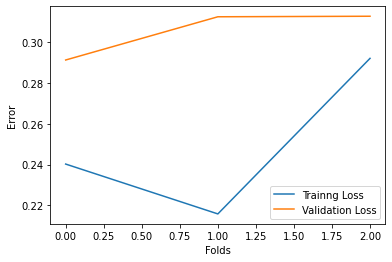

In [16]:
plt.plot(train_loss, label = "Trainng Loss")
plt.plot(vald_loss, label = "Validation Loss")
# naming the x axis 
plt.xlabel('Folds') 
# naming the y axis 
plt.ylabel('Error') 
# function to show the plot 
plt.legend()
plt.savefig('Bert_results/Plots/bert_loss_check.png')

In [17]:
test_loss = []
with tf.device('/device:GPU:0'):
  for i in range(n_splits):
    checkpoint_filepath = 'Bert_results/CheckPoints/bert_checkpoint'+str(i+1) 
    best_model = tf.keras.models.load_model(
                                            checkpoint_filepath, custom_objects=None, compile=True, options=None
                                            )
    predicted = best_model.predict(bert_test_input[0:50])
    
    loss_test = best_model.evaluate([bert_test_input[0],bert_test_input[1],bert_test_input[2]]
                                      , bert_test_output, verbose=0)
    print("Test Errror for the fold ",i+1," is",loss_test )
    
    
    plt.plot(predicted[0:50], label = "Predicted Values")  
    plt.plot(bert_test_output[0:50], label = "Actual Values")
    # naming the x axis 
    plt.xlabel('Test Samples') 
    # naming the y axis 
    plt.ylabel('Output Values') 
    # function to show the plot 
    plt.legend()
    textstr = "Test Errror for the fold "+ str(i+1)+" is "+str(np.round(loss_test,3))
    plt.gcf().text(0, -0.25, textstr, fontsize=14)
    plt.savefig('Bert_results/Plots/bert_fold'+str(i+1)+'.png',bbox_inches='tight')
    plt.clf()

    test_loss.append(loss_test)

Test Errror for the fold  1  is 0.36968231201171875
Test Errror for the fold  2  is 0.2545454502105713
Test Errror for the fold  3  is 0.5410878658294678


<Figure size 432x288 with 0 Axes>

Training Loss: 0.249 (0.032)
Validation Loss: 0.305 (0.010)
Test Loss: 0.388 (0.118)


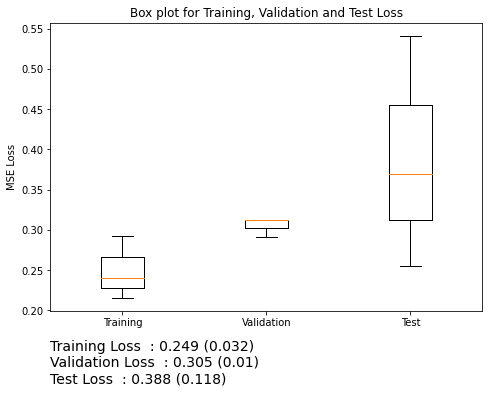

In [18]:
import matplotlib.pylab as plt
data=[]
data.append(train_loss)
data.append(vald_loss)
data.append(test_loss)
  
fig = plt.figure()  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
  
# Creating plot 
ax.boxplot(data)

ax.set_xticklabels(['Training', 'Validation','Test']) 

# naming the y axis 
plt.ylabel('MSE Loss')
plt.title("Box plot for Training, Validation and Test Loss")
textstr ='Training Loss  : '+str(np.round(np.mean(train_loss),3))+' ('+str(np.round(np.std(train_loss),3))+')\n'+'Validation Loss  : '+str(np.round(np.mean(vald_loss),3))+' ('+str(np.round(np.std(vald_loss),3))+')\n'+'Test Loss  : '+str(np.round(np.mean(test_loss),3))+' ('+str(np.round(np.std(test_loss),3))+')'
plt.gcf().text(0, -0.25, textstr, fontsize=14)
# show plot 
plt.savefig('Bert_results/Plots/block_bert.png',bbox_inches='tight')

print('Training Loss: %.3f (%.3f)' % (np.mean(train_loss), np.std(train_loss)))
print('Validation Loss: %.3f (%.3f)' % (np.mean(vald_loss), np.std(vald_loss)))
print('Test Loss: %.3f (%.3f)' % (np.mean(test_loss), np.std(test_loss)))

In [1]:
!zip -r /content/file.zip /content/Bert_results
from google.colab import files
files.download("/content/file.zip")

	zip warning: name not matched: /content/Bert_results

zip error: Nothing to do! (try: zip -r /content/file.zip . -i /content/Bert_results)


FileNotFoundError: ignored